In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import savgol_filter

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_excel('/content/drive/MyDrive/EDISS/Course stuff/NIR_Data.xlsx')

In [6]:
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (773, 1040)


,Sample ID,Unnamed: 1,11988.51,11980.8,11973.08,11965.37,11957.66,11949.94,11942.23,11934.51,...,4057.888,4050.173,4042.459,4034.744,4027.03,4019.315,4011.601,4003.886,3996.171,Moisture
0,3001RanBioMixMalarenergi.0,1,0.430391,0.430351,0.430570,0.430974,0.431129,0.430807,0.430425,0.430264,...,1.042346,1.052940,1.062511,1.070474,1.077419,1.082571,1.084933,1.086961,1.088756,24.933532
1,3001RanBioMixMalarenergi.1,2,0.418378,0.418387,0.418783,0.418983,0.418721,0.418339,0.417951,0.417494,...,1.017335,1.027128,1.036592,1.043992,1.049032,1.051711,1.052812,1.054065,1.055364,24.933532
2,3001RanBioMixMalarenergi.2,3,0.446782,0.446930,0.446840,0.446419,0.446009,0.445715,0.445539,0.445537,...,1.053265,1.061849,1.070649,1.079960,1.088810,1.094708,1.098719,1.100796,1.099144,24.933532
3,3001RanBioMixMalarenergi.3,4,0.434038,0.433805,0.433692,0.433850,0.433912,0.433757,0.433515,0.433327,...,1.020629,1.029372,1.038613,1.047470,1.053009,1.054695,1.054589,1.053924,1.053708,24.933532
4,3001RanBioMixMalarenergi.4,5,0.451491,0.451441,0.451692,0.451816,0.451755,0.451595,0.451293,0.451114,...,1.013404,1.023107,1.030855,1.036464,1.042622,1.049984,1.055300,1.055122,1.052386,24.933532


In [7]:
print("Data Description:")
print(df.describe())

Data Description:
       Unnamed: 1    11988.51     11980.8    11973.08    11965.37    11957.66  \
count  773.000000  773.000000  773.000000  773.000000  773.000000  773.000000   
mean   408.213454    0.555737    0.555510    0.555277    0.555048    0.554840   
std    248.050920    0.175660    0.175460    0.175265    0.175117    0.174975   
min      1.000000    0.267237    0.267553    0.267540    0.267290    0.267120   
25%    200.000000    0.420672    0.420877    0.421411    0.421568    0.421270   
50%    393.000000    0.499081    0.498969    0.498818    0.498389    0.497959   
75%    598.000000    0.687495    0.687133    0.687137    0.686687    0.685944   
max    949.000000    0.978465    0.977729    0.975623    0.973480    0.972385   

         11949.94    11942.23    11934.51     11926.8  ...    4057.888  \
count  773.000000  773.000000  773.000000  773.000000  ...  773.000000   
mean     0.554626    0.554355    0.554071    0.553910  ...    1.317717   
std      0.174754    0.174469 

Separating features and target variable

In [29]:
X = df.drop(columns=["Moisture"])
y = df["Moisture"]
X = X.reset_index(drop=True)

**Outlier Detection for Moisture**

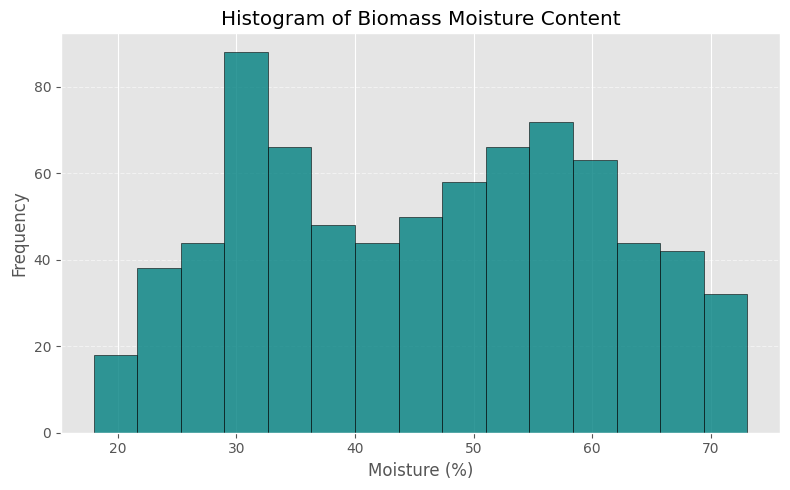

In [21]:
plt.figure(figsize=(8, 5))
plt.hist(df["Moisture"], bins=15, color='teal', edgecolor='black', alpha=0.8)
plt.title("Histogram of Biomass Moisture Content")
plt.xlabel("Moisture (%)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

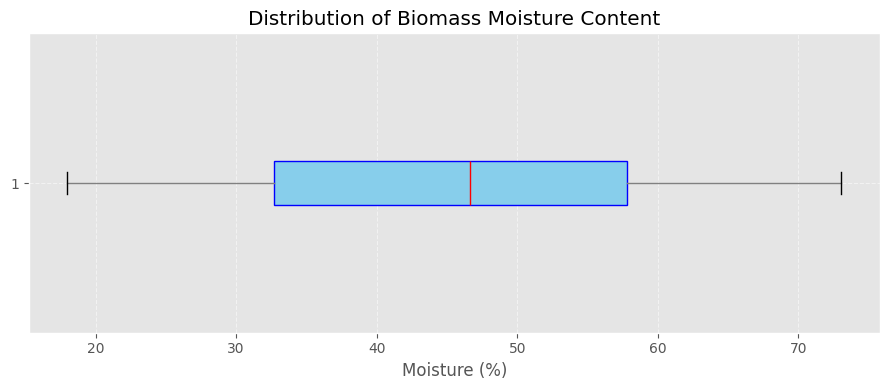

In [20]:
# Moisture distribution: boxplot
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4))
plt.boxplot(df["Moisture"], vert=False, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='gray'))

plt.title("Distribution of Biomass Moisture Content")
plt.xlabel("Moisture (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [27]:
from scipy.stats import zscore

z_scores = zscore(df["Moisture"])

threshold = 2.5
outlier_mask = np.abs(z_scores) > threshold
outliers = df[outlier_mask]

print(f"Number of outliers detected: {outliers.shape[0]}")
outliers

Number of outliers detected: 0


,Sample ID,Unnamed: 1,11988.51,11980.8,11973.08,11965.37,11957.66,11949.94,11942.23,11934.51,...,4057.888,4050.173,4042.459,4034.744,4027.03,4019.315,4011.601,4003.886,3996.171,Moisture


In [24]:
Q1 = df["Moisture"].quantile(0.25)
Q3 = df["Moisture"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = df[(df["Moisture"] < lower_bound) | (df["Moisture"] > upper_bound)]

print(f"Number of outliers detected using IQR: {iqr_outliers.shape[0]}")
iqr_outliers

Number of outliers detected using IQR: 0


,Sample ID,Unnamed: 1,11988.51,11980.8,11973.08,11965.37,11957.66,11949.94,11942.23,11934.51,...,4057.888,4050.173,4042.459,4034.744,4027.03,4019.315,4011.601,4003.886,3996.171,Moisture


# **Pre-processing**

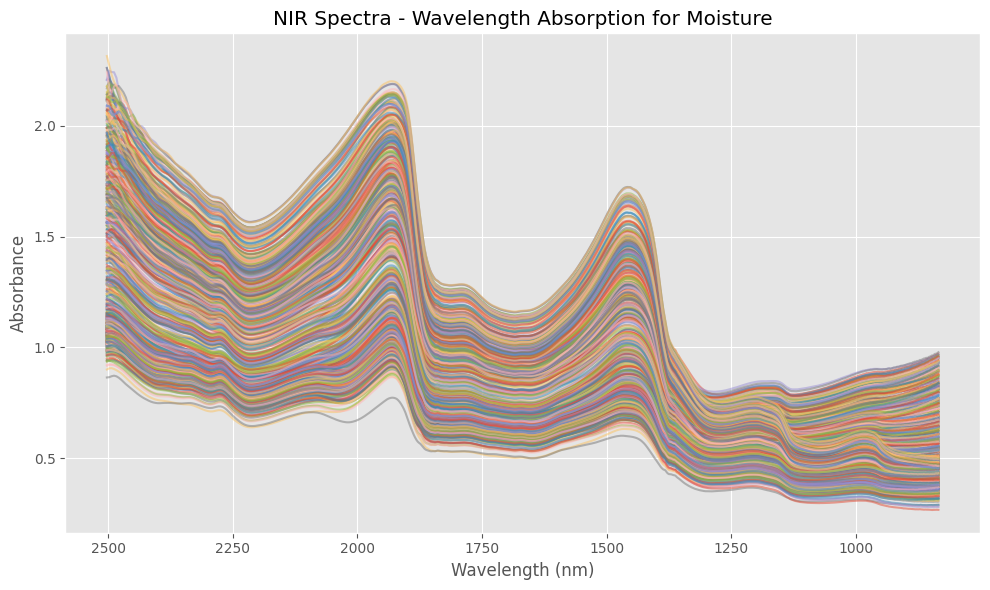

In [37]:
y = df['Moisture'].values
data = df.drop(['Moisture'], axis=1)
spectral_cols = data.columns[2:]

wavenumbers = []
for col in spectral_cols:
    if isinstance(col, (int, float)):
        wavenumbers.append(float(col))
    else:
        try:
            wavenumbers.append(float(str(col).replace(',', '.')))
        except ValueError:
            print(f"Warning: Could not convert column name '{col}' to a number")

wavenumbers = np.array(wavenumbers)
wavelengths = 1e7 / wavenumbers
X = data.iloc[:, 2:].values

plt.figure(figsize=(10, 6))

for i in range(X.shape[0]):
    plt.plot(wavelengths, X[i], alpha=0.5)

plt.title("NIR Spectra - Wavelength Absorption for Moisture")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

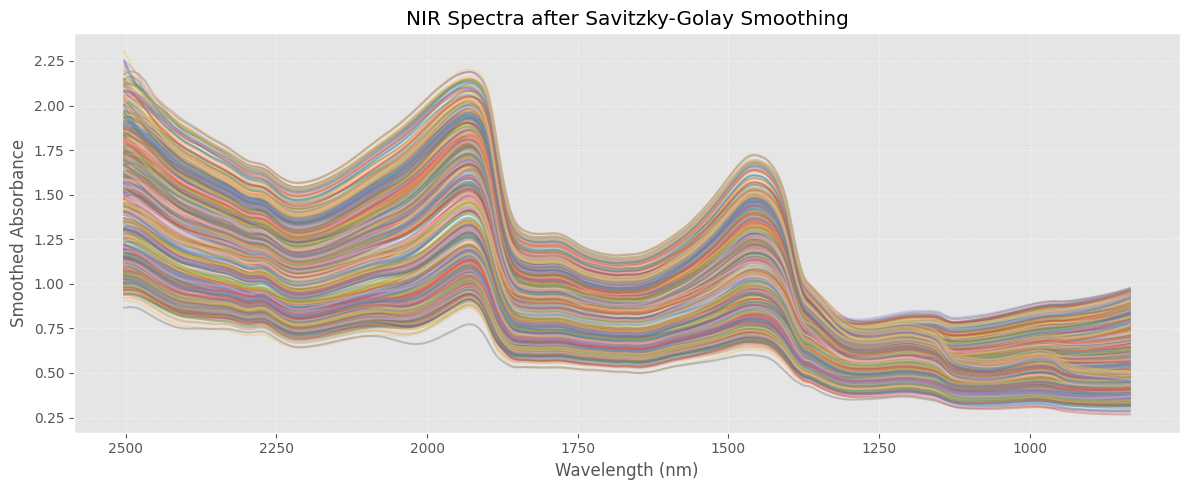

In [46]:
from scipy.signal import savgol_filter

wavenumbers = []
for col in spectral_cols:
    if isinstance(col, (int, float)):
        wavenumbers.append(float(col))
    else:
        try:
            wavenumbers.append(float(str(col).replace(',', '.')))
        except ValueError:
            print(f"Warning: Could not convert column name '{col}' to a number")

wavenumbers = np.array(wavenumbers)
wavelengths = 1e7 / wavenumbers
X = data.iloc[:, 2:].values
X_smooth = savgol_filter(X, window_length=11, polyorder=2, axis=1)

plt.figure(figsize=(12, 5))
for spectrum in X_smooth:
    plt.plot(wavelengths, spectrum, alpha=0.4)
plt.title("NIR Spectra after Savitzky-Golay Smoothing")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Smoothed Absorbance")
plt.grid(True, linestyle='--', alpha=0.4)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

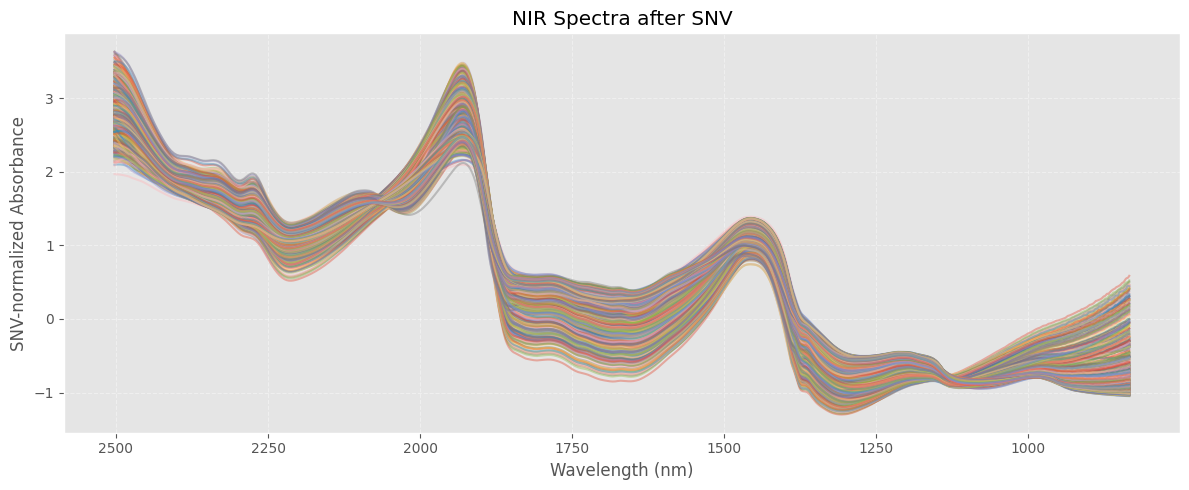

In [49]:
def apply_snv(X):
    return (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

X_snv = apply_snv(X_smooth)

plt.figure(figsize=(12, 5))
for spectrum in X_snv:
    plt.plot(wavelengths, spectrum, alpha=0.4)
plt.title("NIR Spectra after SNV")
plt.xlabel("Wavelength (nm)")
plt.ylabel("SNV-normalized Absorbance")
plt.grid(True, linestyle='--', alpha=0.4)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

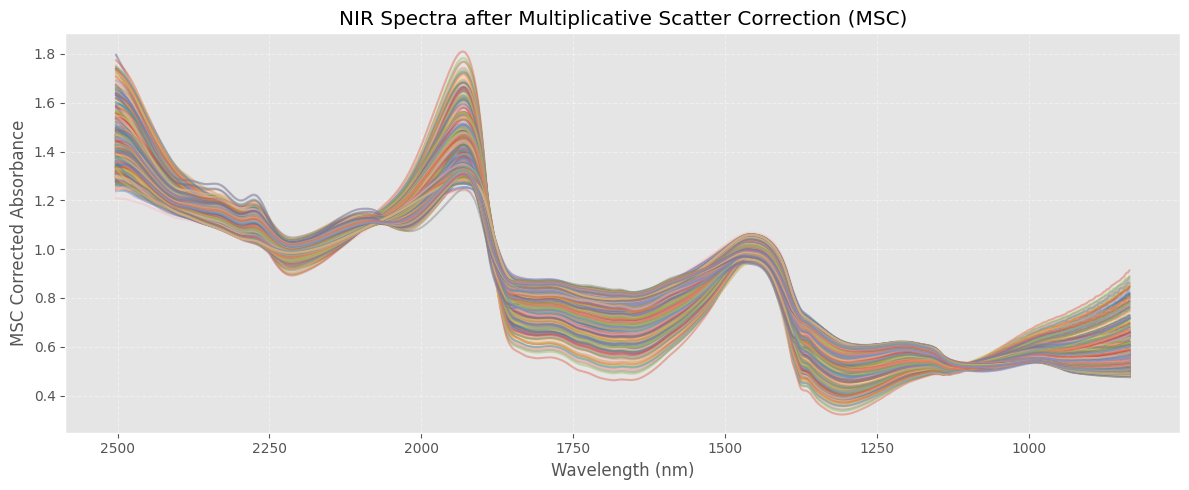

In [50]:
def apply_msc(X):
    mean_spectrum = np.mean(X, axis=0)
    X_msc = np.zeros_like(X)
    for i in range(X.shape[0]):
        fit = np.polyfit(mean_spectrum, X[i, :], deg=1, full=False)
        X_msc[i, :] = (X[i, :] - fit[1]) / fit[0]
    return X_msc

X_msc = apply_msc(X_smooth)
plt.figure(figsize=(12, 5))
for spectrum in X_msc:
    plt.plot(wavelengths, spectrum, alpha=0.4)
plt.title("NIR Spectra after Multiplicative Scatter Correction (MSC)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("MSC Corrected Absorbance")
plt.grid(True, linestyle='--', alpha=0.4)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

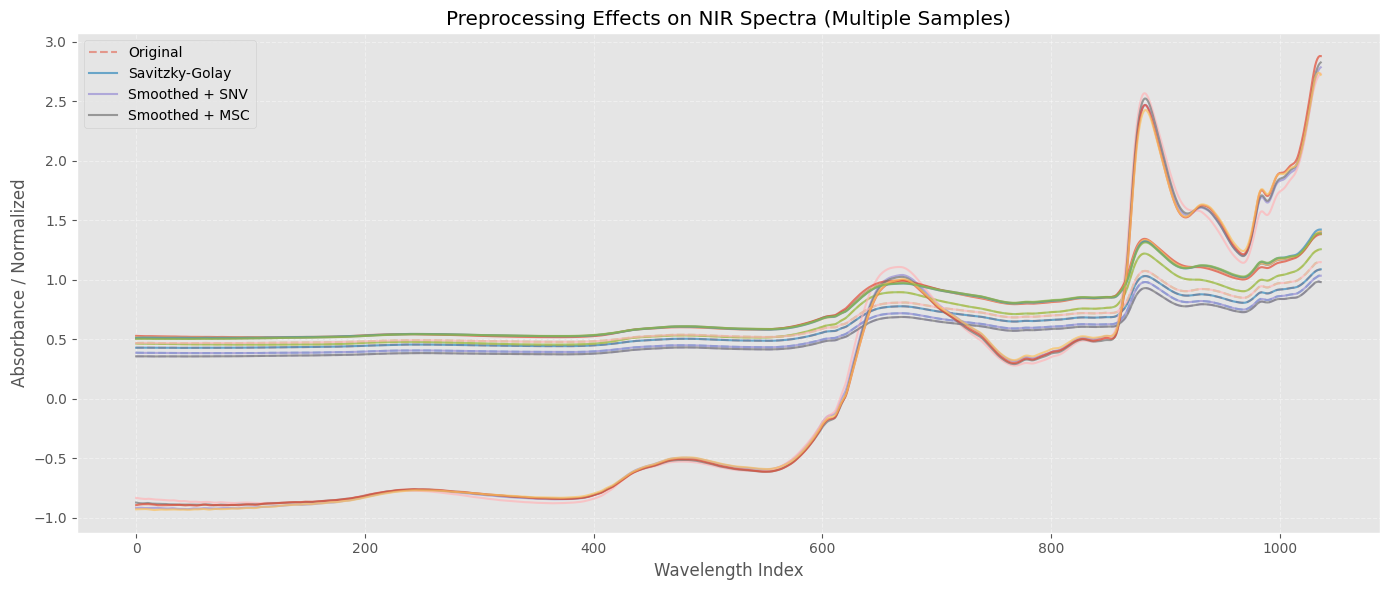

In [51]:
plt.figure(figsize=(14, 6))
samples_to_plot = [0, 10, 20, 30, 40]  # Change indices as needed

for i in samples_to_plot:
    plt.plot(X[i], alpha=0.5, linestyle="--", label="Original" if i == samples_to_plot[0] else "")
    plt.plot(X_smooth[i], alpha=0.7, label="Savitzky-Golay" if i == samples_to_plot[0] else "")
    plt.plot(X_snv[i], alpha=0.7, label="Smoothed + SNV" if i == samples_to_plot[0] else "")
    plt.plot(X_msc[i], alpha=0.7, label="Smoothed + MSC" if i == samples_to_plot[0] else "")

plt.title("Preprocessing Effects on NIR Spectra (Multiple Samples)")
plt.xlabel("Wavelength Index")
plt.ylabel("Absorbance / Normalized")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

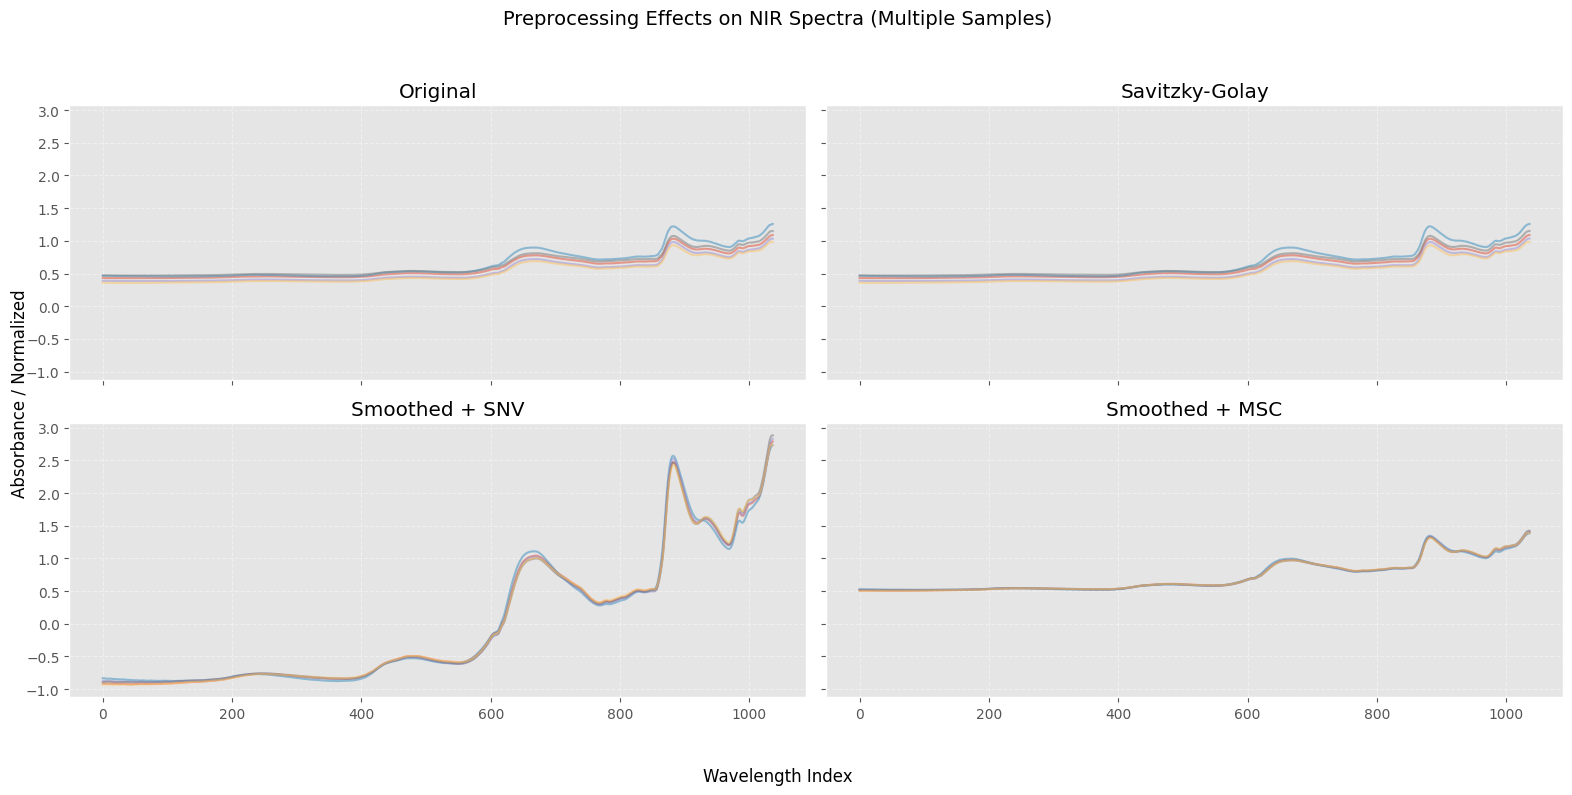

In [53]:
samples_to_plot = [0, 10, 20, 30, 40]
fig, axs = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True)

# Original
for i in samples_to_plot:
    axs[0, 0].plot(X[i], alpha=0.5)
axs[0, 0].set_title("Original")
axs[0, 0].grid(True, linestyle='--', alpha=0.4)

# Savitzky-Golay
for i in samples_to_plot:
    axs[0, 1].plot(X_smooth[i], alpha=0.5)
axs[0, 1].set_title("Savitzky-Golay")
axs[0, 1].grid(True, linestyle='--', alpha=0.4)

# SNV
for i in samples_to_plot:
    axs[1, 0].plot(X_snv[i], alpha=0.5)
axs[1, 0].set_title("Smoothed + SNV")
axs[1, 0].grid(True, linestyle='--', alpha=0.4)

# MSC
for i in samples_to_plot:
    axs[1, 1].plot(X_msc[i], alpha=0.5)
axs[1, 1].set_title("Smoothed + MSC")
axs[1, 1].grid(True, linestyle='--', alpha=0.4)

fig.suptitle("Preprocessing Effects on NIR Spectra (Multiple Samples)", fontsize=14)
fig.supxlabel("Wavelength Index")
fig.supylabel("Absorbance / Normalized")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_smooth_scaled = scaler.fit_transform(X_smooth)
X_snv_scaled    = scaler.fit_transform(X_snv)
X_msc_scaled    = scaler.fit_transform(X_msc)

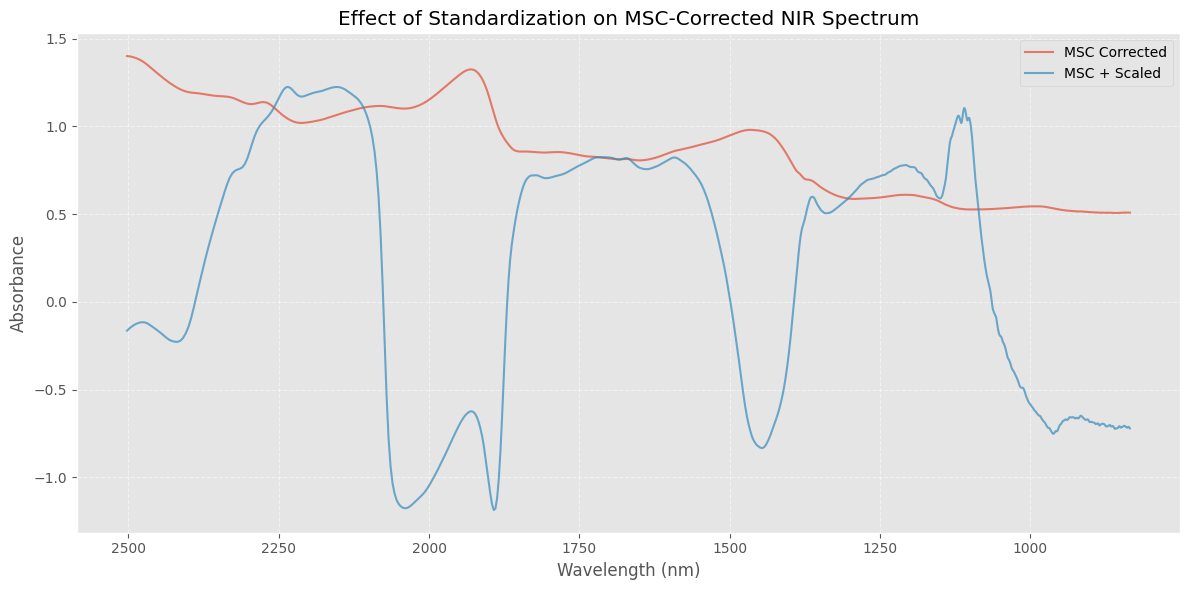

In [57]:
sample_idx = 0
plt.figure(figsize=(12, 6))
plt.plot(wavelengths, X_msc[sample_idx], label="MSC Corrected", alpha=0.7)
plt.plot(wavelengths, X_scaled_msc[sample_idx], label="MSC + Scaled", alpha=0.7)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Effect of Standardization on MSC-Corrected NIR Spectrum")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

# **Model Training**

In [59]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_pls(X, y, name, n_components=10):
    pls = PLSRegression(n_components=n_components)
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    y_pred = cross_val_predict(pls, X, y, cv=cv)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return {"Preprocessing": name, "R2": r2, "RMSECV": rmse}

results = []

results.append(evaluate_pls(X_smooth_scaled, y, "Savitzky-Golay"))
results.append(evaluate_pls(X_snv_scaled, y, "S-G + SNV"))
results.append(evaluate_pls(X_msc_scaled, y, "S-G + MSC"))

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

    Preprocessing        R2    RMSECV
0  Savitzky-Golay  0.953790  3.101759
1       S-G + SNV  0.970165  2.492344
2       S-G + MSC  0.969708  2.511342


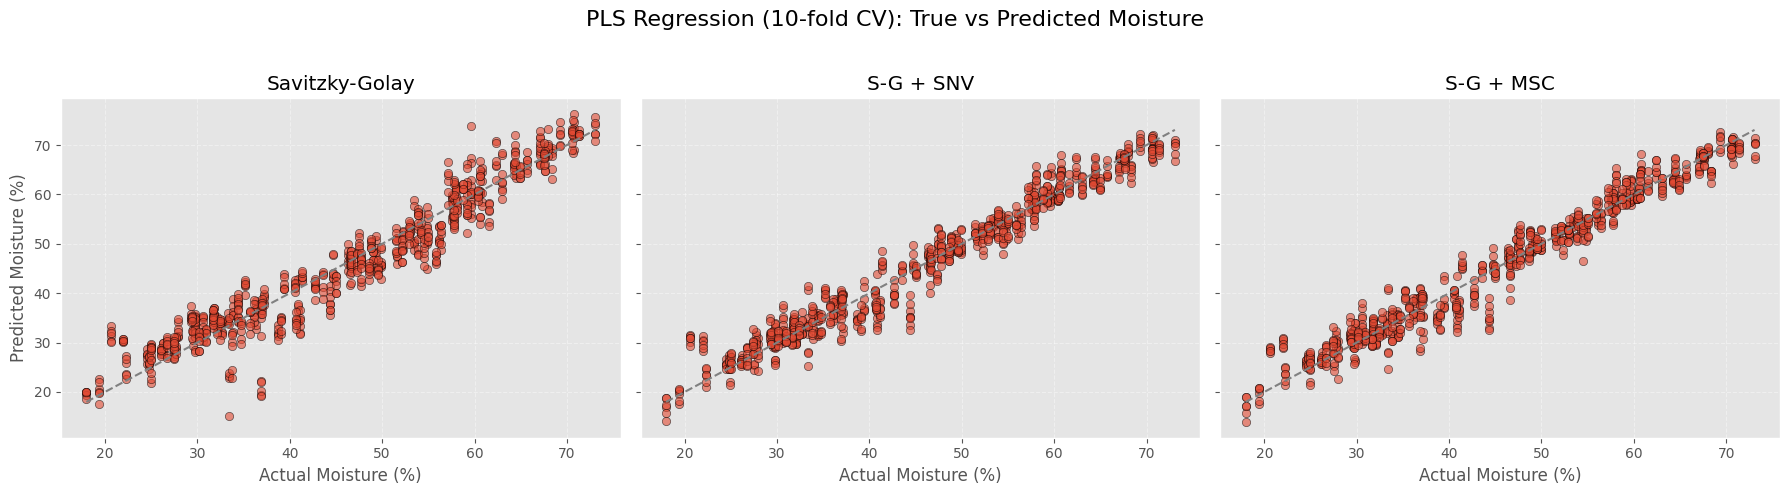

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

preprocessed_sets = [
    ("Savitzky-Golay", X_smooth_scaled),
    ("S-G + SNV", X_snv_scaled),
    ("S-G + MSC", X_msc_scaled)
]

for i, (label, X_input) in enumerate(preprocessed_sets):
    pls = PLSRegression(n_components=10)
    y_pred = cross_val_predict(pls, X_input, y, cv=10)

    axs[i].scatter(y, y_pred, edgecolors='k', alpha=0.6)
    axs[i].plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
    axs[i].set_title(f"{label}")
    axs[i].set_xlabel("Actual Moisture (%)")
    if i == 0:
        axs[i].set_ylabel("Predicted Moisture (%)")
    axs[i].grid(True, linestyle='--', alpha=0.4)

fig.suptitle("PLS Regression (10-fold CV): True vs Predicted Moisture", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Support Vector Regression

In [61]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def evaluate_svr(X, y, name):
    svr = SVR(kernel='rbf', C=100, epsilon=0.1)
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    y_pred = cross_val_predict(svr, X, y, cv=cv)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return {"Preprocessing": name, "R2": r2, "RMSECV": rmse}

svr_results = []
svr_results.append(evaluate_svr(X_smooth_scaled, y, "Savitzky-Golay"))
svr_results.append(evaluate_svr(X_snv_scaled, y, "S-G + SNV"))
svr_results.append(evaluate_svr(X_msc_scaled, y, "S-G + MSC"))

svr_results_df = pd.DataFrame(svr_results)
print(svr_results_df)

    Preprocessing        R2    RMSECV
0  Savitzky-Golay  0.939406  3.551858
1       S-G + SNV  0.974998  2.281533
2       S-G + MSC  0.975000  2.281449


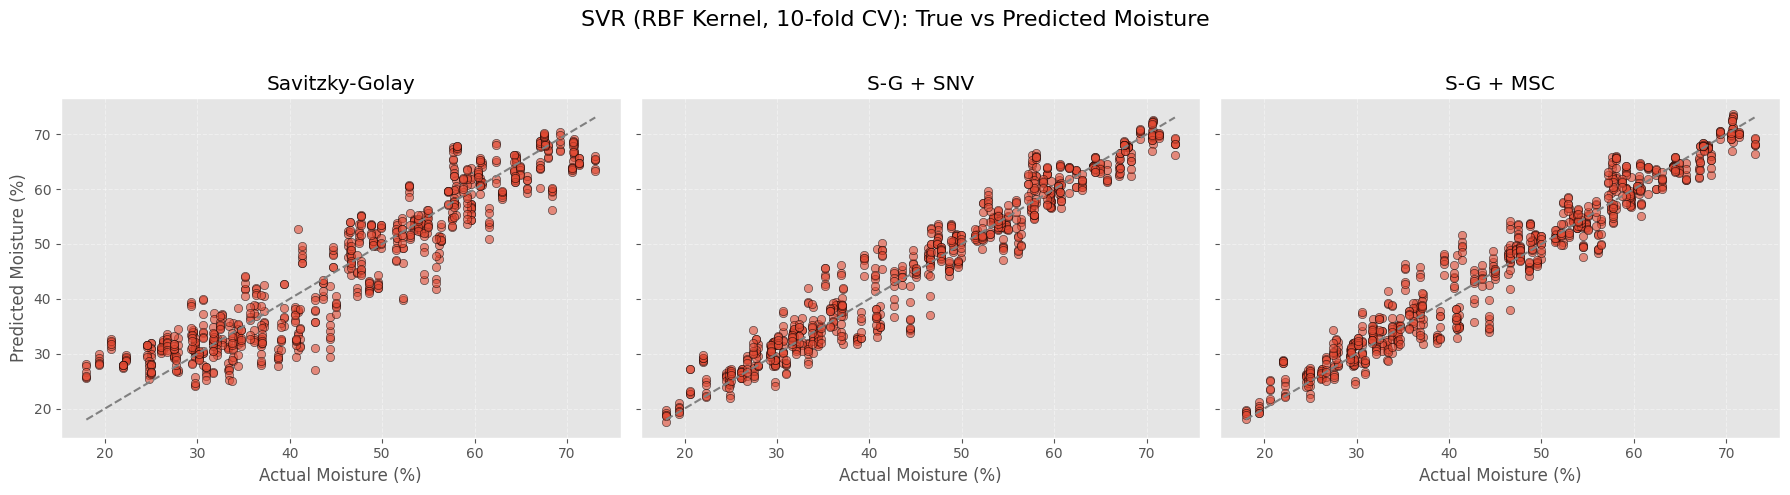

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

preprocessed_sets = [
    ("Savitzky-Golay", X_smooth_scaled),
    ("S-G + SNV", X_snv_scaled),
    ("S-G + MSC", X_msc_scaled)
]

for i, (label, X_input) in enumerate(preprocessed_sets):
    svr = SVR(kernel='rbf', C=100, epsilon=0.1)
    y_pred = cross_val_predict(svr, X_input, y, cv=10)

    axs[i].scatter(y, y_pred, edgecolors='k', alpha=0.6)
    axs[i].plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
    axs[i].set_title(f"{label}")
    axs[i].set_xlabel("Actual Moisture (%)")
    if i == 0:
        axs[i].set_ylabel("Predicted Moisture (%)")
    axs[i].grid(True, linestyle='--', alpha=0.4)

fig.suptitle("SVR (RBF Kernel, 10-fold CV): True vs Predicted Moisture", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

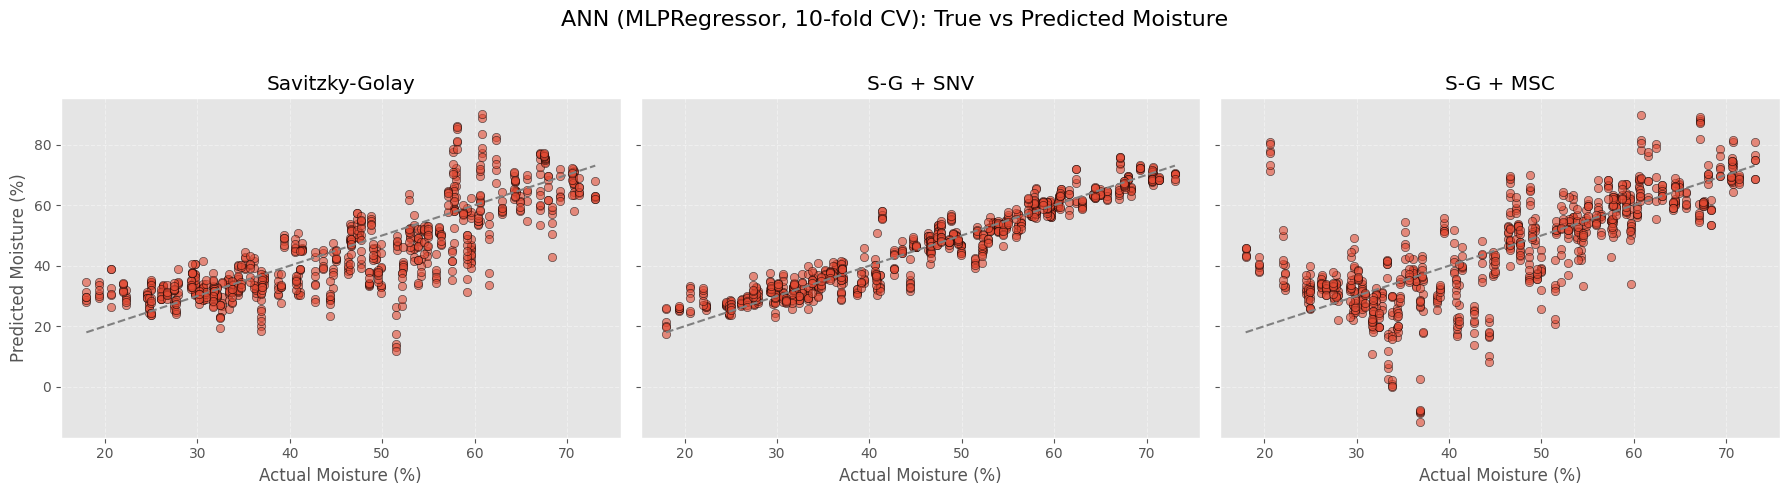

    Preprocessing        R2     RMSECV
0  Savitzky-Golay  0.602051   9.102380
1       S-G + SNV  0.925240   3.945250
2       S-G + MSC  0.328057  11.827901


In [63]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

preprocessed_sets = [
    ("Savitzky-Golay", X_smooth_scaled),
    ("S-G + SNV", X_snv_scaled),
    ("S-G + MSC", X_msc_scaled)
]

ann_results = []

for i, (label, X_input) in enumerate(preprocessed_sets):
    ann = MLPRegressor(hidden_layer_sizes=(100,), activation='relu',
                       solver='adam', max_iter=1000, random_state=42)

    y_pred = cross_val_predict(ann, X_input, y, cv=10)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    ann_results.append({"Preprocessing": label, "R2": r2, "RMSECV": rmse})

    axs[i].scatter(y, y_pred, edgecolors='k', alpha=0.6)
    axs[i].plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
    axs[i].set_title(f"{label}")
    axs[i].set_xlabel("Actual Moisture (%)")
    if i == 0:
        axs[i].set_ylabel("Predicted Moisture (%)")
    axs[i].grid(True, linestyle='--', alpha=0.4)

fig.suptitle("ANN (MLPRegressor, 10-fold CV): True vs Predicted Moisture", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Print results
ann_results_df = pd.DataFrame(ann_results)
print(ann_results_df)

**Model Comparison**

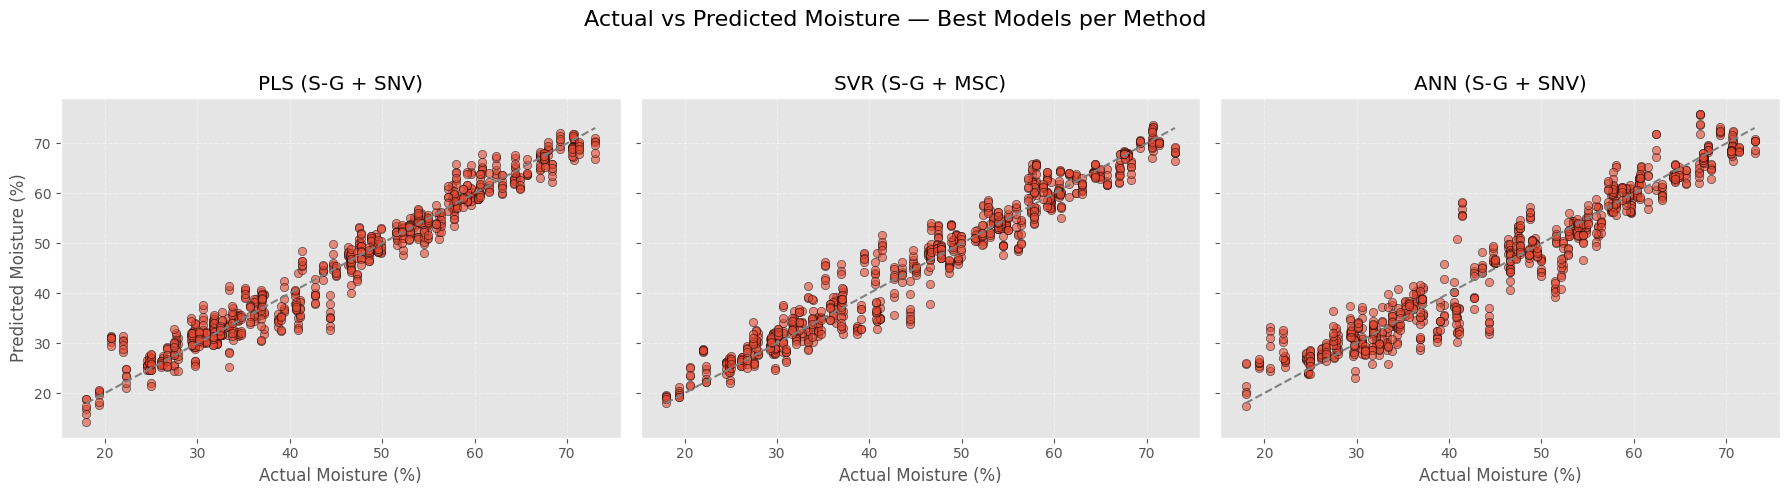

In [65]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# === PLS: S-G + SNV ===
pls = PLSRegression(n_components=10)
y_pred_pls = cross_val_predict(pls, X_snv_scaled, y, cv=10)
axs[0].scatter(y, y_pred_pls, edgecolors='k', alpha=0.6)
axs[0].plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
axs[0].set_title("PLS (S-G + SNV)")
axs[0].set_xlabel("Actual Moisture (%)")
axs[0].set_ylabel("Predicted Moisture (%)")
axs[0].grid(True, linestyle='--', alpha=0.4)

# === SVR: S-G + MSC ===
svr = SVR(kernel='rbf', C=100, epsilon=0.1)
y_pred_svr = cross_val_predict(svr, X_msc_scaled, y, cv=10)
axs[1].scatter(y, y_pred_svr, edgecolors='k', alpha=0.6)
axs[1].plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
axs[1].set_title("SVR (S-G + MSC)")
axs[1].set_xlabel("Actual Moisture (%)")
axs[1].grid(True, linestyle='--', alpha=0.4)

# === ANN: S-G + SNV ===
ann = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
y_pred_ann = cross_val_predict(ann, X_snv_scaled, y, cv=10)
axs[2].scatter(y, y_pred_ann, edgecolors='k', alpha=0.6)
axs[2].plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
axs[2].set_title("ANN (S-G + SNV)")
axs[2].set_xlabel("Actual Moisture (%)")
axs[2].grid(True, linestyle='--', alpha=0.4)

fig.suptitle("Actual vs Predicted Moisture — Best Models per Method", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

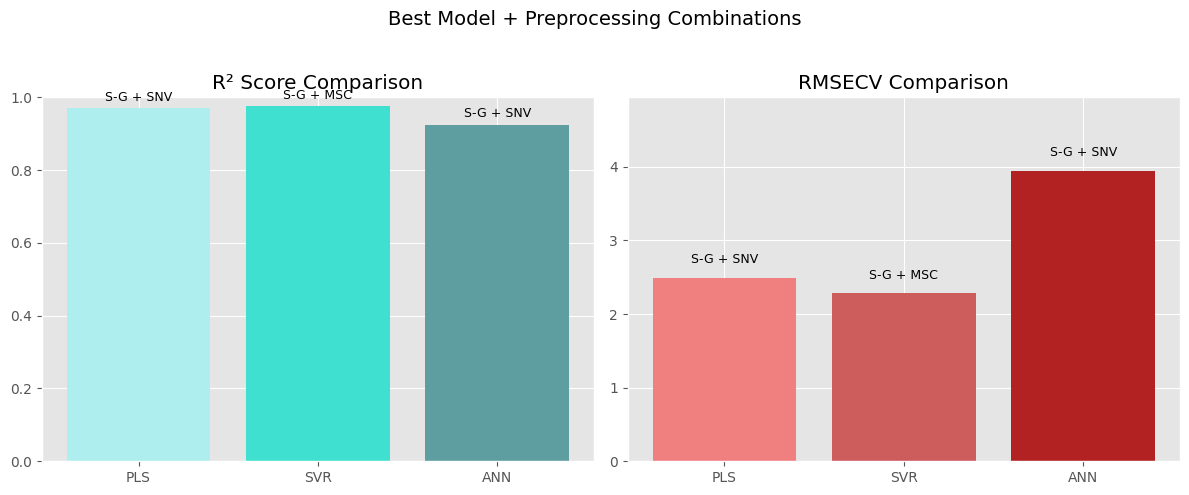

In [70]:
import matplotlib.pyplot as plt

models = ["PLS", "SVR", "ANN"]
r2_scores = [0.9702, 0.9750, 0.9252]
rmse_scores = [2.4923, 2.2814, 3.9453]
preprocessing = ["S-G + SNV", "S-G + MSC", "S-G + SNV"]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# R² Bar Plot
axs[0].bar(models, r2_scores, color=['paleturquoise', 'turquoise', 'cadetblue'])
axs[0].set_title("R² Score Comparison")
axs[0].set_ylim(0, 1)
for i, txt in enumerate(preprocessing):
    axs[0].text(i, r2_scores[i] + 0.02, txt, ha='center', fontsize=9)

# RMSECV Bar Plot
axs[1].bar(models, rmse_scores, color=['lightcoral', 'indianred', 'firebrick'])
axs[1].set_title("RMSECV Comparison")
axs[1].set_ylim(0, max(rmse_scores) + 1)
for i, txt in enumerate(preprocessing):
    axs[1].text(i, rmse_scores[i] + 0.2, txt, ha='center', fontsize=9)

plt.suptitle("Best Model + Preprocessing Combinations", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()